# The wavy ramp

In this example, we will integrate the dynamics of a point mass bouncing down a non-linear ramp. The point mass behaves like a rubber ball, meaning that at every bounce it will dissipate part of its kinetic energy due to the [inelastic](https://en.wikipedia.org/wiki/Inelastic_collision) character of the collisions.

Let us begin, as usual, with the definition of the dynamics:

In [1]:
import heyoka as hy

x, y, vx, vy = hy.make_vars("x", "y", "vx", "vy")

eqns = [(x, vx),
        (y, vy),
        (vx, hy.expression(0.)),
        # Downwards constant acceleration.
        (vy, hy.expression(-9.8))]

In other words, we are setting up a 2D dynamical system in which the only acceleration is due to the (constant) gravitational field.

The contour of the ramp is defined by the non-linear equation

$$
y = 1 - x + 0.05 \cos\left(11 \pi x \right).
$$

Let us take a look:

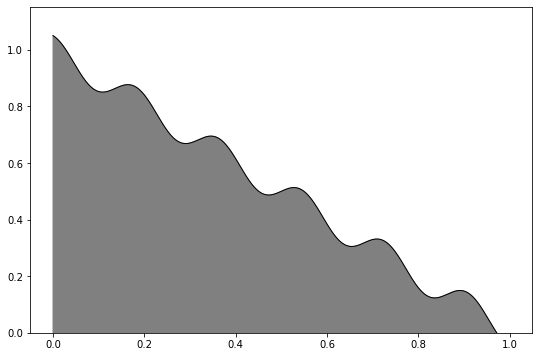

In [2]:
from matplotlib.pylab import plt
import numpy as np
plt.rcParams["figure.figsize"] = (9,6)

fig = plt.figure()
x_grid = np.linspace(0, 1., 1000)
plt.plot(x_grid, (1 - x_grid + 0.05 * np.cos(11 * np.pi * x_grid)), 'k-', linewidth=1)
plt.fill_between(x_grid, -1., (1 - x_grid + 0.05 * np.cos(11 * np.pi * x_grid)), color='gray')
plt.ylim(0, None);

We want the particle to bounce off both the wavy ramp and the ground (i.e., $x$ axis). Thus, we will have to define two different event equations and two different callback functions to implement the bouncing behaviour. Let us begin with the event equations:

In [3]:
# Event equation for the ramp.
eq_w_curve = y - (1. - x + 0.05 * hy.cos(11 * np.pi * x))

# Event equation for the ground.
eq_bottom = y

Next, we need to implement the callbacks. Because we are dealing with inelastic collisions, when the particle hits a surface it will lose part of its kinetic energy. The [coefficient of restitution](https://en.wikipedia.org/wiki/Coefficient_of_restitution) $C_R \in \left[0, 1\right]$ regulates how much energy is lost at every bounce.

Additionally, because of the loss of energy, the particle will experience increasingly frequent collisions if it gets stuck in one of the local minima of the curve or when it starts bouncing off the ground. In practice, we want to stop the simulation once the collisions become too frequent.

Let us see the code:

In [4]:
# The coefficient of restitution.
CR = .8

# Global variables to track
# the time of the last collision
# and the collision points.
last_t = 0.
bounce_points = []

# Callback for bouncing against the curve.
def cb_w_curve(ta, mr, d_sgn):
    global last_t

    # If the last collision happened
    # too recently, return False to
    # stop the simulation.
    if ta.time - last_t < 1e-10:
        return False

    # Update last_t.
    last_t = ta.time

    # Update bounce_points.
    x, y = ta.state[0:2]
    bounce_points.append((x, y))
    
    # Compute the normal unit vector
    # using the gradient of the event
    # equation.
    grad = np.array([1+0.05*11*np.pi*np.sin(11*np.pi*x), 1])
    grad_uvec = grad / np.linalg.norm(grad)
    
    # Compute the component of the velocity
    # across the normal vector.
    xy_vel = ta.state[2:4]
    vproj = np.dot(xy_vel, grad_uvec)
    
    # Flip it and rescale it according
    # to the coefficient of restitution.
    Dv = -vproj*grad_uvec
    xy_vel += (1. + CR) * Dv

    return True

# Callback for bouncing off the ground.
def cb_bottom(ta, mr, d_sgn):
    global last_t

    # If the last collision happened
    # too recently, return False to
    # stop the simulation.
    if ta.time - last_t < 1e-10:
        return False

    # Update last_t.
    last_t = ta.time

    # Update bounce_points.
    x, y = ta.state[0:2]
    bounce_points.append((x, y))
    
    # Flip the y component of the velocity,
    # and rescale it according
    # to the coefficient of restitution.
    ta.state[3] = -CR*ta.state[3]
    
    return True

We are now ready to create the integrator object. As initial conditions, we will put the particle at rest above the ramp on the $y$ axis:

In [5]:
ta = hy.taylor_adaptive(eqns, [0, 1.2, 0, 0], t_events = [hy.t_event(eq_w_curve, callback = cb_w_curve, direction = hy.event_direction.negative),
                                                          hy.t_event(eq_bottom, callback = cb_bottom, direction = hy.event_direction.negative)])

Note how, as explained in the [Keplerian billiard](<./The Keplerian billiard.ipynb>) example, we assigned specific directions to the collision events. This is done in order to avoid triggering spurious double-bounce events that would lead to the particle penetrating through the ramp or the ground.

We can now integrate the system for a few time units:

In [6]:
t_grid = np.linspace(0, 10, 10000)
oc, _, _, _, res = ta.propagate_grid(t_grid)

# Transform bounce_points in a NumPy array
# for ease of use.
b_points = np.array(bounce_points)

Let us take a look at the trajectory:

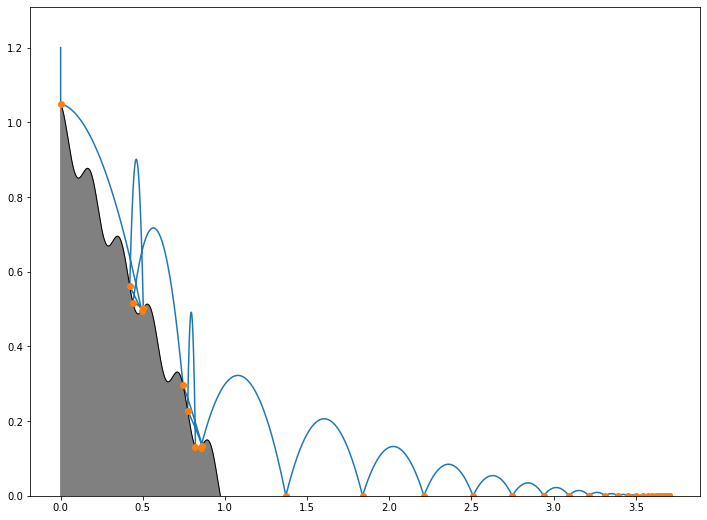

In [7]:
plt.rcParams["figure.figsize"] = (12,9)
fig = plt.figure()
plt.plot(res[:,0],res[:,1])
x_grid = np.linspace(0, 1., 1000)
plt.plot(x_grid, (1 - x_grid + 0.05 * np.cos(11 * np.pi * x_grid)), 'k-', linewidth=1)
plt.plot(b_points[:, 0], b_points[:, 1], 'o')
plt.fill_between(x_grid, -1., (1 - x_grid + 0.05 * np.cos(11 * np.pi * x_grid)), color='gray')
plt.ylim(0, None);

We can clearly see the dissipative behaviour of the inelastic collisions at play. Indeed, despite the fact that we asked to integrate the system up to $t=10$, the integration was stopped at

In [8]:
ta.time

4.739023056879299

instead, and the outcome ``oc`` informs us that the integration was stopped because of a stopping terminal event:

In [9]:
oc

<taylor_outcome.???: -2>

A value of ``oc`` negative and greater than ``taylor_outcome.success`` indicates a stopping terminal event. The index of the stopping terminal event is ``-oc - 1``:

In [10]:
print("Stopped by terminal event? {}".format(oc > hy.taylor_outcome.success and int(oc) < 0))
print("Index of the terminal event: {}".format(-int(oc)-1))

Stopped by terminal event? True
Index of the terminal event: 1
